In [1]:
from _utils import *

2024-10-21 18:18:48.027024: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 18:18:48.070638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def preprocessing_samples_pca(distance_map_flat_list,
                              sample_labels, num_microstates):
    sample_labels = np.array(sample_labels)
    pca = PCA(n_components=2)
    pca.fit(distance_map_flat_list)
    pca_samples = []
    unique_labels = np.unique(sample_labels)
    for label in unique_labels:
        pca_samples.append(pca.transform(distance_map_flat_list[sample_labels == label, :]))
        
    df_sample_list = []
    for i, label in enumerate(unique_labels):
        df_sample = pd.DataFrame(pca_samples[i], columns=['PC1', 'PC2'])
        df_sample['label'] = label
        df_sample_list.append(df_sample)
    df_samples = pd.concat(df_sample_list, axis=0)
    
    min_pc1 = df_samples['PC1'].min()
    max_pc1 = df_samples['PC1'].max()
    min_pc2 = df_samples['PC2'].min()
    max_pc2 = df_samples['PC2'].max()
    
    num_microstate_per_axis = np.round(np.sqrt(num_microstates), 0).astype(int)
    
    microstate_distance_maps = generate_microstates(
        min_pc1, max_pc1, min_pc2, max_pc2, num_microstate_per_axis, pca)
    
    data_dict = {
        'df_samples': df_samples,
        'microstate_distance_maps': microstate_distance_maps
    }
    
    return data_dict

In [62]:
dataset_path = '/mnt/home/tudomlumleart/ceph/15_SimonDataset/df20240311_posrate30-50p.mat'
dataset = scipy.io.loadmat(dataset_path)
dataset_list = [dataset['df'][:, i][0][0] for i in range(4)] 

# Remove the samples with more than 50% missing data
dataset_list_filtered = []
for sample in tqdm(dataset_list):
    sample_list = []
    for trace_id in range(sample.shape[2]):
        trace = sample[:, :, trace_id]
        nan_frac = np.mean(np.isnan(trace)[:, 0])
        if nan_frac < 0.5:
            sample_list.append(trace)
    sample_list = np.array(sample_list)
    # reshape such that the third dimension is the number of traces
    sample_list = np.transpose(sample_list, (1, 2, 0))
    dataset_list_filtered.append(np.array(sample_list))

# Interpolate the missing data
dataset_polys_interp = []
dataset_polys = []
for sample in dataset_list: 
    print(sample.shape)
    dataset_polys_interp.append(interpolate_polymers(sample))
for sample in dataset_list_filtered:
    dataset_polys.append(sample)
    
# for sample in dataset_list_filtered: 
#     print(sample.shape)
#     dataset_polys.append(interpolate_polymers(sample))
    
dataset_maps_interp = []
dataset_maps = []
for sample in dataset_polys_interp:
    print(sample.shape)
    dataset_maps_interp.append(calculate_distance_map(sample))
for sample in dataset_polys:
    dataset_maps.append(calculate_distance_map(sample))

    
dataset_maps_flat = []
label_list = []
for i, sample in enumerate(dataset_maps):
    curr_data_flat = [x.flatten() for x in sample]
    dataset_maps_flat.append(curr_data_flat)
    label_list.extend([str(i)] * len(curr_data_flat))
    
dataset_maps_all = np.concatenate(dataset_maps, axis=0)
dataset_maps_flat_all = np.concatenate(dataset_maps_flat, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

(51, 3, 3107)
(51, 3, 4574)
(51, 3, 4760)
(51, 3, 4289)
(51, 3, 3107)
(51, 3, 4574)
(51, 3, 4760)
(51, 3, 4289)


In [43]:
dataset_maps[1].shape

(2115, 51, 51)

In [26]:
sample.shape

(1719, 51, 3, 3107)

In [5]:
data_dict = preprocessing_samples_pca(dataset_maps_flat_all, np.array(label_list), 75**2)

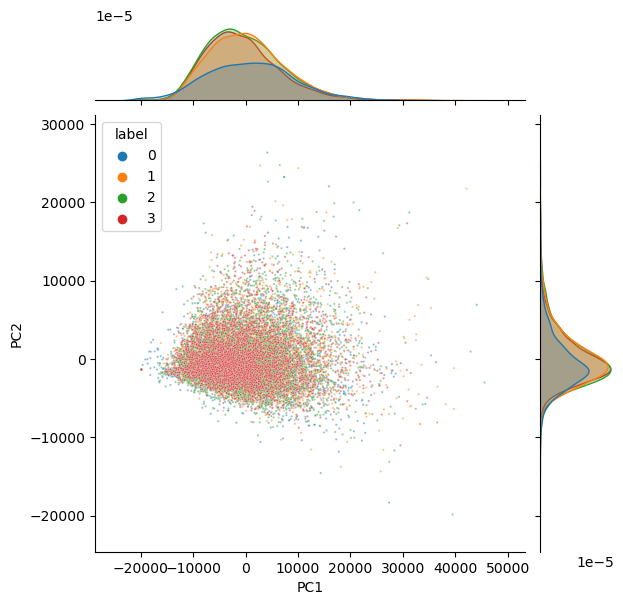

In [9]:
sns.jointplot(data=data_dict['df_samples'], x='PC1', y='PC2', hue='label', marker='.', s=10, alpha=0.5)

In [70]:
mcmc_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241021_RunWeightMCMC_Simon_PCA'

mcmc_result = load_mcmc_results(mcmc_dir, 75**2)

  0%|          | 0/4 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241021173944_1.csv', '20240715_WeightOptimization-20241021173944_2.csv', '20240715_WeightOptimization-20241021173944_3.csv', '20240715_WeightOptimization-20241021173944_4.csv']
['20240715_WeightOptimization-20241021173949_1.csv', '20240715_WeightOptimization-20241021173949_2.csv', '20240715_WeightOptimization-20241021173949_3.csv', '20240715_WeightOptimization-20241021173949_4.csv']
['20240715_WeightOptimization-20241021173944_1.csv', '20240715_WeightOptimization-20241021173944_2.csv', '20240715_WeightOptimization-20241021173944_3.csv', '20240715_WeightOptimization-20241021173944_4.csv']
['20240715_WeightOptimization-20241021173944_1.csv', '20240715_WeightOptimization-20241021173944_2.csv', '20240715_WeightOptimization-20241021173944_3.csv', '20240715_WeightOptimization-20241021173944_4.csv']


In [89]:
weight_result = {}
entropy_dfs = []

for i, k in enumerate(sorted(mcmc_result.keys())):
    curr_sample = mcmc_result[k]
    weights = np.exp(np.array(curr_sample))
    weights = weights.reshape(-1, 75**2)
    weight_result[k] = weights
    
    entropies = calculate_entropy(weights)
    entropy_df = pd.DataFrame({'entropy': entropies, 'label': k})
    entropy_dfs.append(entropy_df)
    
entropy_df_all = pd.concat(entropy_dfs, axis=0)

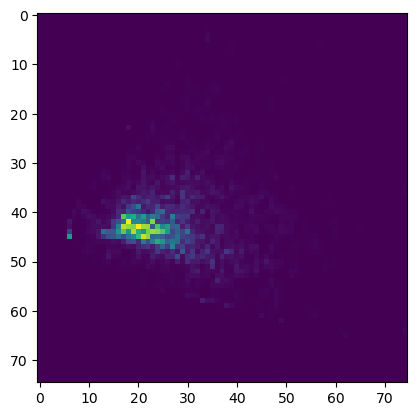

In [79]:

plt.imshow(weight_result['0'].mean(axis=0).reshape(75, 75).T)

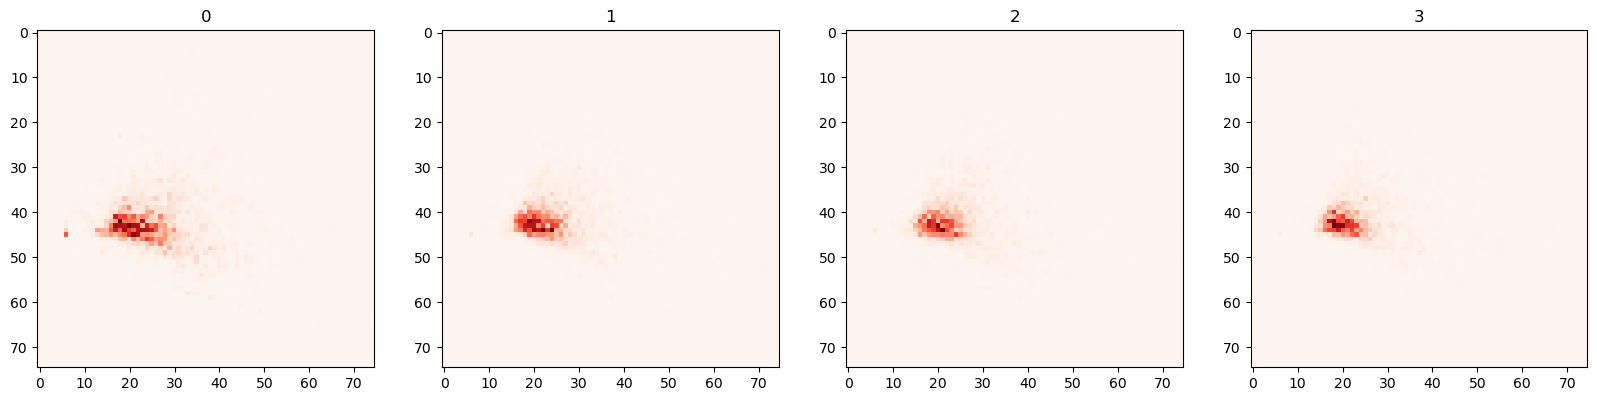

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, k in enumerate(sorted(weight_result.keys())):
    ax[i].imshow(weight_result[k].mean(axis=0).reshape(75, 75).T, cmap='Reds')
    ax[i].set_title(k)


<Axes: xlabel='label', ylabel='entropy'>

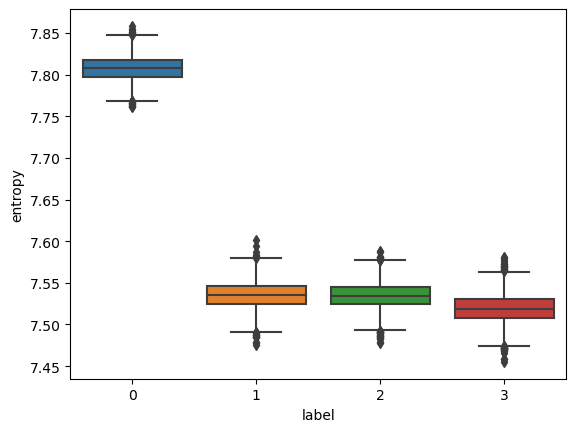

In [91]:
sns.boxplot(data=entropy_df_all, x='label', y='entropy')

In [55]:
med_dmap_list_interp = []
for dmap in dataset_maps_interp:
    med_dmap_list_interp.append(np.median(dmap, axis=0))

In [54]:
dataset_maps_interp[0].shape

(3107, 51, 51)

In [63]:
med_dmap_list = []
for dmap in dataset_maps:
    med_dmap_list.append(np.nanmedian(dmap, axis=0))

In [38]:
dataset_maps[0].shape

(1719, 51, 51)

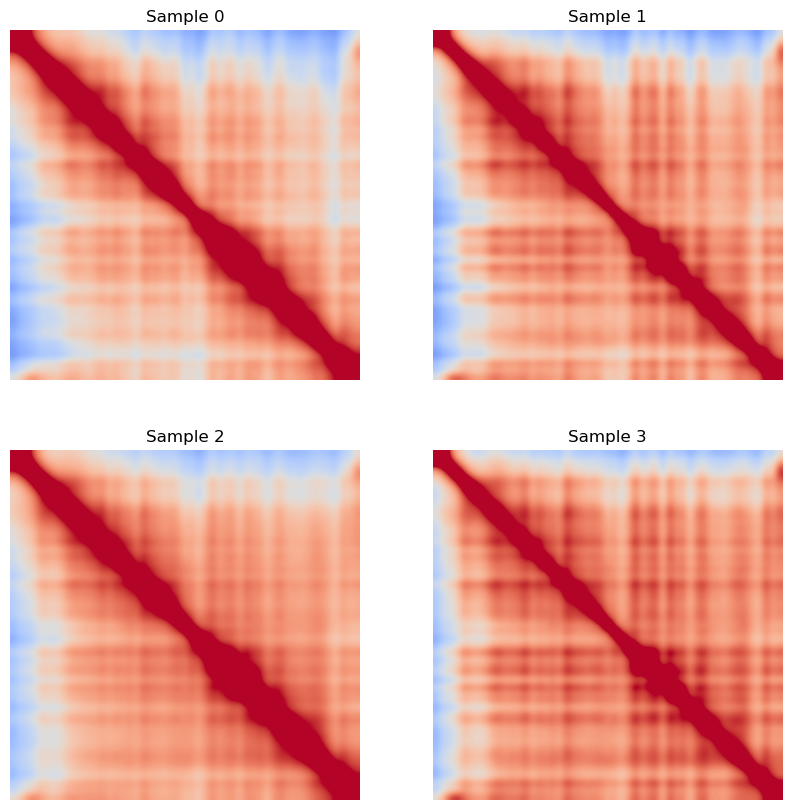

In [66]:
# Plot the median distance map
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, dmap in enumerate(med_dmap_list_interp):
    ax[i//2, i%2].imshow(dmap, cmap='coolwarm_r', vmin=200, vmax=600, interpolation='bicubic')
    ax[i//2, i%2].set_title(f'Sample {i}')
    ax[i//2, i%2].axis('off')

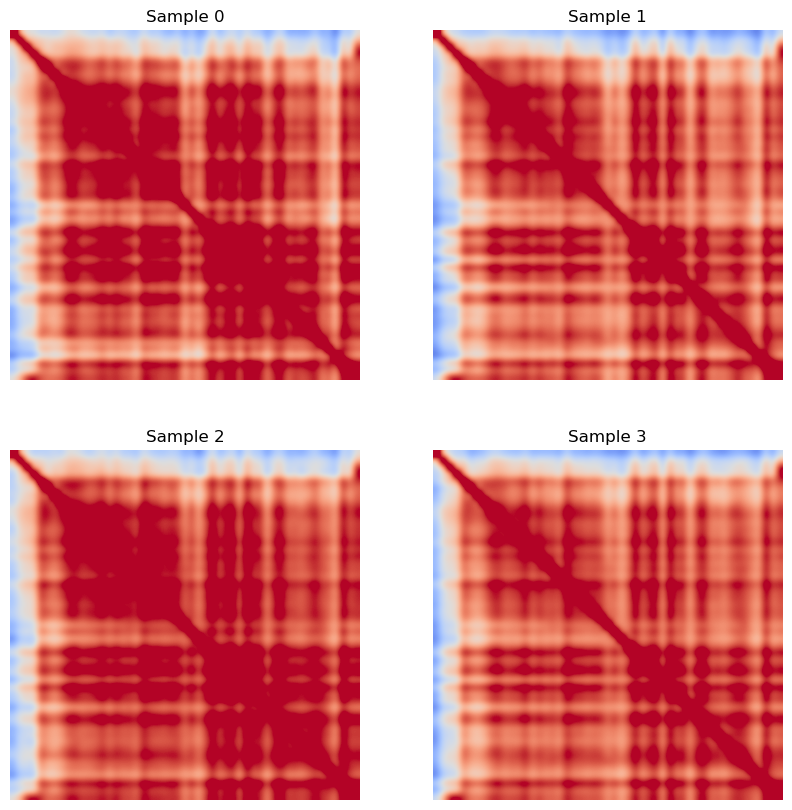

In [67]:
# Plot the median distance map
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, dmap in enumerate(med_dmap_list):
    ax[i//2, i%2].imshow(dmap, cmap='coolwarm_r', vmin=200, vmax=600, interpolation='bicubic')
    ax[i//2, i%2].set_title(f'Sample {i}')
    ax[i//2, i%2].axis('off')